In [1]:
%matplotlib inline

In [31]:
from pyiron_atomistics import Project
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

In [17]:
pr = Project('ANNNI_19')

# Helping Functions

## Structures 

In [18]:
def structure_minimization (reference_structure, potential):
    job_mini = pr.create_job(pr.job_type.Lammps, job_name='lmp_mini')
    job_mini.structure =  reference_structure
    job_mini.potential =  potential
    job_mini.calc_minimize(pressure=0.0)
    job_mini.run(delete_existing_job=True)
    minimum_structure = job_mini.get_structure()  
    return minimum_structure

In [19]:
def fcc_structure(minimum_structure):
    supercell_size = round((len(minimum_structure)/2)**(1/3))
    a_hcp = minimum_structure.cell[0][0]/(supercell_size)
    c_over_a = minimum_structure.cell[2][2]/minimum_structure.cell[0][0]
    a_fcc = (((a_hcp)**3)*(np.sqrt(3)* (c_over_a)))**(1/3)
    element = minimum_structure.get_chemical_symbols()[0]
    fcc_struc= pr.create.structure.bulk(element,crystalstructure="fcc", a=a_fcc, cubic=True).repeat(supercell_size)
    return  fcc_struc

In [20]:
def dhcp_structure(minimum_structure): #or hcp struc 
    supercell_size = round((len(minimum_structure)/2)**(1/3))
    a_hcp = minimum_structure.cell[0][0]/(supercell_size)
    c_over_a = minimum_structure.cell[2][2]/minimum_structure.cell[0][0]
    element = minimum_structure.get_chemical_symbols()[0]
    dhcp_unitcell= pr.create.structure.bulk(element,crystalstructure="hcp",a = a_hcp, covera= c_over_a, orthorhombic=False).repeat([1,1,2])
    new_pos=[]
    for i in range(len(dhcp_unitcell)):
        if i == 3 :
            pos = dhcp_unitcell.get_positions()[i] + [a_hcp/2, -((np.sqrt(3)/2)*a_hcp)/3, 0.0]
        else:
            pos = dhcp_unitcell.get_positions()[i] +[0.0, 0.0, 0.0]   
        new_pos.append(pos)
    dhcp_unitcell.set_positions(new_pos)
    dhcp_hcp_struc = dhcp_unitcell.repeat(supercell_size)
    return dhcp_hcp_struc

In [21]:
def hcp_structure(minimum_structure):
    supercell_size = round((len(minimum_structure)/4)**(1/3))
    a_fcc = minimum_structure.cell[0][0]/(supercell_size)
    a_hcp = (((a_fcc)**3)/(np.sqrt(3)* (np.sqrt(8/3))))**(1/3)
    element = minimum_structure.get_chemical_symbols()[0]
    hcp_struc = pr.create.structure.bulk(element,crystalstructure="hcp",a = a_hcp).repeat(supercell_size)
    return hcp_struc

In [22]:
def SF_structures(minimum_structure):
    if minimum_structure.get_symmetry().spacegroup["Number"] in range(195, 231,1):
        SF_structure_1 = hcp_structure(minimum_structure)
        SF_structure_2 = dhcp_structure(SF_structure_1)
        print("reference structure is fcc")
    else:
        SF_structure_1 = fcc_structure(minimum_structure)
        SF_structure_2 = dhcp_structure(minimum_structure)
        print("reference structure is hcp")
    return SF_structure_1, SF_structure_2

## Zero_Kelvin Energy 

In [23]:
def calculate_0K_energy(structure, potential):
    job_strain_template = pr.create.job.Lammps(job_name='lmp'+ str(round(structure.cell.cellpar()[2])))
    job_strain_template.potential = potential
    job_strain_template.structure = structure
    job_strain_bulk = job_strain_template.copy_to(new_job_name='Bulk'+ str(round(structure.cell.cellpar()[2])), new_database_entry=False)
    murn_strain = pr.create.job.Murnaghan(job_name='Murn'+ str(round(structure.cell.cellpar()[2])))
    murn_strain.ref_job = job_strain_bulk
    murn_strain.run()
    zeroK_energy = (murn_strain["output/energy"])/len(structure)
    return zeroK_energy

## Temperature_Dependence Energy

In [24]:
def calculate_qh_energy_volume(structure, potential, temperature, steps):
    job_strain_template = pr.create.job.Lammps(job_name='lmp'+ str(round(structure.cell.cellpar()[2])))
    job_strain_template.potential = potential
    job_strain_template.structure = structure
    phono_strain = pr.create.job.PhonopyJob(job_name='phono_'+ str(round(structure.cell.cellpar()[2])))
    phono_strain.ref_job = job_strain_template
    quasi_strain = pr.create.job.QuasiHarmonicJob(job_name='quasi_'+ str(round(structure.cell.cellpar()[2])))
    quasi_strain.ref_job = phono_strain
    quasi_strain.input["temperature_end"] = temperature
    quasi_strain.input["temperature_steps"] = steps
    quasi_strain.input["axes"]=["x","y","z"]
    quasi_strain.input["strains"] = None
    quasi_strain.run()
    energy = (quasi_strain["output/free_energy"].T)/len(structure)
    volume = (quasi_strain["output/volumes"].T)/len(structure)
    return energy, volume

## SFE Calculation 

In [25]:
def SFE_calculation_hcp(E_ref_structure, E_SF_structure_1, E_SF_structure_2, V_ref_structure, minimum_structure):
    Ahcp_T       = []
    del_free_eng_I1 = []
    del_free_eng_I2 = []
    SFE_T_I1 = []
    SFE_T_I2 = []
    covera = minimum_structure.cell[2][2]/minimum_structure.cell[0][0]
    for i in range(len(E_ref_structure)):
        min_index = E_ref_structure[i].argmin()
        Ahcp_T.append(((np.sqrt(3)/2)* ((4*V_ref_structure[i][min_index]/(np.sqrt(3)*covera))**(2/3))))
        del_free_eng_I1.append((2*(E_SF_structure_2[i][min_index]- E_ref_structure[i][min_index]))*1000)
        del_free_eng_I2.append(((E_SF_structure_1[i][min_index])+(2*E_SF_structure_2[i][min_index])-(3*E_ref_structure[i][min_index]))* 1000)
        SFE_T_I1.append(del_free_eng_I1[i] /Ahcp_T[i])
        SFE_T_I2.append(del_free_eng_I2[i] /Ahcp_T[i])
    return SFE_T_I1, SFE_T_I2

In [26]:
def SFE_calculation_fcc(E_ref_structure, E_SF_structure_1, E_SF_structure_2, V_ref_structure):
    Afcc_T       = []
    del_free_eng_I1 = []
    del_free_eng_I2 = []
    SFE_T_I1 = []
    SFE_T_I2 = []
    for i in range(len(E_ref_structure)):
        min_index = E_ref_structure[i].argmin()
        Afcc_T.append((np.sqrt(3)/4)* ((4*V_ref_structure[i][min_index])**(2/3)))
        del_free_eng_I1.append((2*(E_SF_structure_1[i][min_index]- E_ref_structure[i][min_index]))*1000)
        del_free_eng_I2.append(((E_SF_structure_1[i][min_index])+(2*E_SF_structure_2[i][min_index])-(3*E_ref_structure[i][min_index]))* 1000)
        SFE_T_I1.append(del_free_eng_I1[i] /Afcc_T[i])
        SFE_T_I2.append(del_free_eng_I2[i] /Afcc_T[i])
    return SFE_T_I1, SFE_T_I2

In [27]:
def ANNNI_model(reference_structure, potential, temperature=None, steps=None):
    energies = []
    volumes = []
    minimum_structure = structure_minimization(reference_structure, potential)
    SFstructures = SF_structures(minimum_structure)
    for structure in [minimum_structure, SFstructures[0], SFstructures[1]]:
        zero_K_energy = calculate_0K_energy(structure, potential)
        qh_energy, qh_volume = calculate_qh_energy_volume(structure, potential, temperature, steps)
        energies.append(zero_K_energy + qh_energy)
        volumes.append(qh_volume)
    if minimum_structure.get_symmetry().spacegroup["Number"] in range(195, 231,1):
        SFE = SFE_calculation_fcc(energies[0], energies[1], energies[2], volumes[0])
    else:
        SFE = SFE_calculation_hcp(energies[0], energies[1], energies[2], volumes[0], minimum_structure)
    return SFE

In [28]:
potential = '1998--Liu-X-Y--Al-Mg--LAMMPS--ipr1'
mg_hcp =  pr.create.structure.bulk('Mg', a = 3.21, orthorhombic=False).repeat(2)
SFE = ANNNI_model(mg_hcp, potential=potential, temperature=800, steps=5)

The job lmp_mini was saved and received the ID: 327
reference structure is hcp
The job Murn10 was saved and received the ID: 328
The job Murn10_0_9 was saved and received the ID: 329
The job Murn10_0_92 was saved and received the ID: 330
The job Murn10_0_94 was saved and received the ID: 331
The job Murn10_0_96 was saved and received the ID: 332
The job Murn10_0_98 was saved and received the ID: 333
The job Murn10_1_0 was saved and received the ID: 334
The job Murn10_1_02 was saved and received the ID: 335
The job Murn10_1_04 was saved and received the ID: 336
The job Murn10_1_06 was saved and received the ID: 337
The job Murn10_1_08 was saved and received the ID: 338
The job Murn10_1_1 was saved and received the ID: 339
The job quasi_10 was saved and received the ID: 340
The job quasi_10_0_9 was saved and received the ID: 341
The job lmp10_0 was saved and received the ID: 342
The job quasi_10_0_92 was saved and received the ID: 343
The job lmp10_0 was saved and received the ID: 344
Th

In [29]:
SFE[0]

[1.6595080315935213,
 1.6136202501814045,
 1.5442294338457236,
 1.492348909862815,
 0.5986677498864809]

In [30]:
SFE[1]

[3.313437080965767,
 3.22709834219003,
 3.0954852237137893,
 2.9985857836408645,
 1.283059817721857]

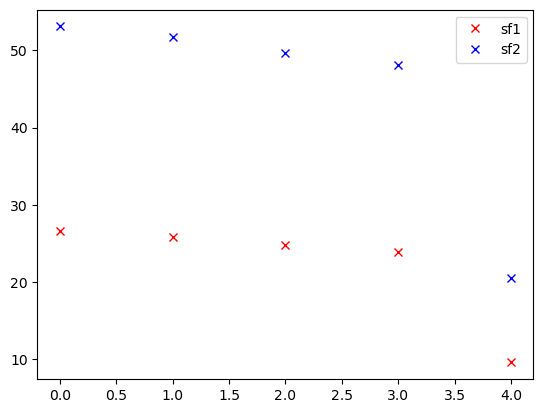

In [34]:
meV_a2_to_mJ_m2 = 16.021766
plt.plot(np.array(SFE[0])*meV_a2_to_mJ_m2,'rx', label="sf1")
plt.plot(np.array(SFE[1])*meV_a2_to_mJ_m2,'bx', label="sf2")
plt.legend()